<a href="https://colab.research.google.com/github/FVaisfeld/ml/blob/main/data_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check for bias between chinese and our data

In this lab, I will check if we need to do some fine tuning or if we can just use the chinese data for training an arrythia model on out data. 



In [ ]:
# Install this package to use Colab's GPU for training
#!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Run the code below to load the dataset `Chinese_Cardisio_Combined.mat` 




---



In [78]:
from scipy import io
import numpy as np

age_temp = io.loadmat('Age.mat')
age = []
[age.append(float(n[0])) for n in age_temp['Age']]
print(age)




sex_temp = io.loadmat('Sex.mat')
sex = []
[sex.append(str(n[0])) for n in sex_temp['Sex']]
print(sex)

labels_temp = io.loadmat('Labels.mat')
labels = []
[labels.append(str(n[0])) for n in labels_temp['Labels_temp']]
print(labels)

#print(age_temp[1])
#sex = np.array(sex)

#import scipy.io
#mat = scipy.io.loadmat('/content/Meta_Data.mat')
#print(mat)
#mat.keys()

#data = np.array(data) # For converting to a NumPy array
#annots[‘annotations’][0][0][‘bbox_x1’], annots[‘annotations’][0][0][‘fname’]
#data = [[row.flat[0] for row in line] for line in annots[‘annotations’][0]]
#columns = [‘bbox_x1’, ‘bbox_y1’, ‘bbox_x2’, ‘bbox_y2’, ‘class’, ‘fname’]
#df_train = pd.DataFrame(data, columns=columns)


[74.0, 49.0, 81.0, 45.0, 53.0, 29.0, 74.0, 80.0, 81.0, 82.0, 87.0, 74.0, 57.0, 76.0, 41.0, 14.0, 60.0, 92.0, 74.0, 27.0, 64.0, 27.0, 67.0, 64.0, 74.0, 74.0, 55.0, 58.0, 35.0, 46.0, 62.0, 30.0, 34.0, 61.0, 52.0, 62.0, 42.0, 55.0, 17.0, 28.0, 40.0, 88.0, 85.0, 84.0, 67.0, 58.0, 31.0, 54.0, 85.0, 67.0, 72.0, 80.0, 76.0, 46.0, 79.0, 51.0, 85.0, 78.0, 28.0, 64.0, 82.0, 66.0, 50.0, 83.0, 66.0, 63.0, 26.0, 55.0, 11.0, 68.0, 82.0, 14.0, 14.0, 80.0, 48.0, 55.0, 50.0, 64.0, 77.0, 74.0, 39.0, 48.0, 62.0, 72.0, 50.0, 65.0, 65.0, 37.0, 49.0, 51.0, 78.0, 54.0, 49.0, 29.0, 53.0, 45.0, 17.0, 31.0, 48.0, 75.0, 79.0, 80.0, 58.0, 48.0, 65.0, 89.0, 26.0, 83.0, 33.0, 40.0, 88.0, 34.0, 40.0, 78.0, 73.0, 70.0, 55.0, 64.0, 82.0, 81.0, 74.0, 83.0, 33.0, 25.0, 87.0, 64.0, 73.0, 53.0, 68.0, 65.0, 72.0, 26.0, 66.0, 56.0, 61.0, 66.0, 50.0, 62.0, 79.0, 34.0, 73.0, 36.0, 48.0, 45.0, 72.0, 52.0, 49.0, 28.0, 85.0, 60.0, 63.0, 52.0, 81.0, 66.0, 55.0, 14.0, 63.0, 32.0, 34.0, 68.0, 49.0, 52.0, 47.0, 57.0, 50.0, 75.0, 66.

Check the personal parameters... 



Text(0, 0.5, 'Age (Years)')

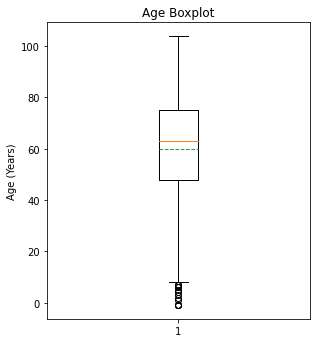

In [85]:
#IMPORTANT: Intentionally plotted different ways for learning purposes only. 

#optional plotting w/pandas: https://pandas.pydata.org/pandas-docs/stable/visualization.html

#we will use matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html

#to organize our graphics will use figure: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
#subplot: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
#and subplotS: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots

#graph distribution of quantitative data
import matplotlib.pyplot as plt

age_temp = []
[age_temp.append(a) for a in age if not np.isnan(a)]

plt.figure(figsize=[16,12])
plt.subplot(231)
plt.boxplot(age_temp, showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

#plt.subplot(232)
#plt.boxplot(sex, showmeans = True, meanline = True)
#plt.title('Sex Boxplot')
#plt.ylabel('Sex')

#plt.subplot(233)
#plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
#plt.title('Family Size Boxplot')
#plt.ylabel('Family Size (#)')

#plt.subplot(234)
#plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
#plt.title('Fare Histogram by Survival')
#plt.xlabel('Fare ($)')
#plt.ylabel('# of Passengers')
#plt.legend()

#plt.subplot(235)
#plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
#plt.title('Age Histogram by Survival')
#plt.xlabel('Age (Years)')
#plt.ylabel('# of Passengers')
#plt.legend()

#plt.subplot(236)
#plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
#plt.title('Family Size Histogram by Survival')
#plt.xlabel('Family Size (#)')
#plt.ylabel('# of Passengers')
#plt.legend()
